In [8]:
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
import numpy as np
import pandas as pd

In [9]:
import rasterio
import geopandas as gpd

raster_path = "E:\Freelancing\WildFire_Paper_CA\Revised_08092025\Fire_Risk_RF_12092025\FireRisk_Classes_RF__grassland.tif"
districts_path = "E:/Freelancing/WildFire_Paper_CA/Districts\Districts.shp"

# Load district shapefile
districts = gpd.read_file(districts_path)

# Load raster CRS
with rasterio.open(raster_path) as src:
    raster_crs = src.crs

# Check and reproject if needed
if districts.crs != raster_crs:
    print("Reprojecting shapefile to match raster CRS...")
    districts = districts.to_crs(raster_crs)


Reprojecting shapefile to match raster CRS...


In [10]:
import os
from rasterio.mask import mask
import fiona
from shapely.geometry import mapping

# Optional: Save reprojected shapefile if needed
# districts.to_file("reprojected_districts.shp")

# Read raster
with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(src, districts.geometry.map(mapping), crop=True)
    out_meta = src.meta.copy()

# Update metadata
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save clipped raster
clipped_raster_path = "clipped_raster.tif"
with rasterio.open(clipped_raster_path, "w", **out_meta) as dest:
    dest.write(out_image)

In [11]:
import pandas as pd
from rasterstats import zonal_stats
import rasterio

# Reuse pixel_area_ha as before
with rasterio.open(clipped_raster_path) as src:
    pixel_size_x, pixel_size_y = src.res
    pixel_area_ha = (30 * 30) / 10000
    pixel_area_km2 = pixel_area_ha / 100  # 1 km² = 100 ha

# Calculate zonal stats on the smaller raster
stats = zonal_stats(
    vectors=districts,
    raster=clipped_raster_path,
    stats=None,
    categorical=True,
    geojson_out=False
)

print(pixel_area_km2)

# Convert stats to DataFrame
df_stats = pd.DataFrame(stats)
df_stats['district'] = districts['district']

# Reshape and calculate area in km²
df_long = df_stats.melt(id_vars='district', var_name='class', value_name='pixel_count')
df_long['area_km2'] = df_long['pixel_count'] * pixel_area_km2

print(df_long['pixel_count'])
# Pivot to wide format: rows = districts, columns = classes, values = km²
result = df_long.pivot_table(index='district', columns='class', values='area_km2', fill_value=0).reset_index()

# Add total area per district
result['Total_km2'] = result.drop(columns='district').sum(axis=1)

# Save result
result.to_csv("E:\Freelancing\WildFire_Paper_CA\Revised_08092025\Fire_Risk_RF_12092025\FireRisk_Classes_RF__forest.csv", index=False)

print(result)


E:\Python\JintuEnv\Lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


0.0009
0      5175809.0
1     49175098.0
2     12527061.0
3     16611235.0
4      5917204.0
         ...    
79     1010527.0
80      263876.0
81      409234.0
82     5009103.0
83      302037.0
Name: pixel_count, Length: 84, dtype: float64
class                         district           0         1          2  \
0                     Angeles District   7689.2733    2.1456   560.9214   
1                    Bay Area District   4727.5767    2.4543   946.5696   
2                     Capital District   4658.2281    0.0441    56.8782   
3              Central Valley District  44257.5882  146.5668  1273.2894   
4               Channel Coast District   7619.6484    0.6849   482.7222   
5             Colorado Desert District  11274.3549    0.4617    42.5115   
6                Diablo Range District  14950.1115    2.8098   841.7088   
7                 Gold Fields District   5325.4836    0.8253    52.3503   
8                 Great Basin District  71890.0866   76.8105  1365.5151   
9         

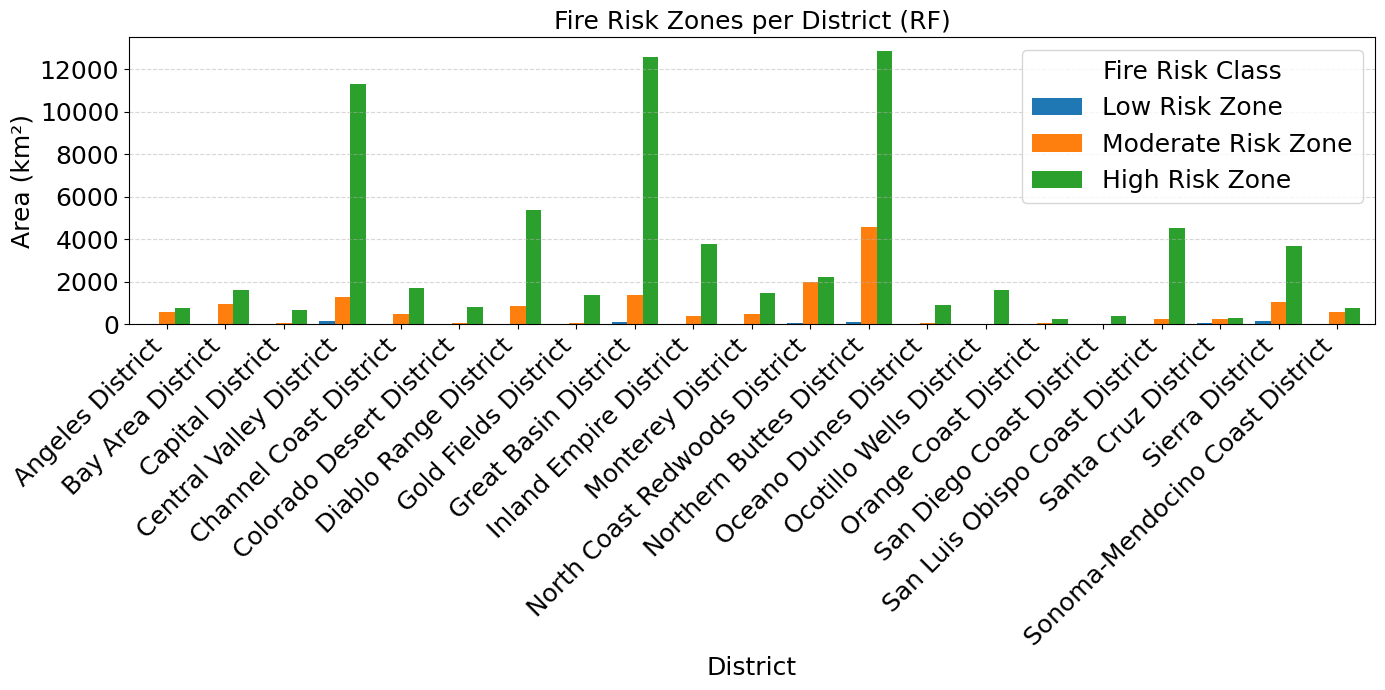

Plot saved to: E:\Freelancing\WildFire_Paper_CA\Revised_08092025\Fire_Risk_RF_12092025\FireRisk_Classes_RF__grassland.png


In [12]:
import matplotlib.pyplot as plt

# Rename class columns to descriptive names
class_rename = {
    1: "Low Risk Zone",
    2: "Moderate Risk Zone",
    3: "High Risk Zone"
}

# Rename columns in result DataFrame
renamed_result = result.rename(columns=class_rename)

# Select only the renamed class columns
columns_to_plot = ["Low Risk Zone", "Moderate Risk Zone", "High Risk Zone"]

# ---------- Plot Fire Risk Zones per District ----------
ax = renamed_result.set_index('district')[columns_to_plot].plot(
    kind='bar',
    figsize=(14, 7),
    width=0.8
)

# Customize fonts
plt.ylabel('Area (km²)', fontsize=18)        # Y-axis label
plt.xlabel('District', fontsize=18)           # X-axis label
plt.title('Fire Risk Zones per District (RF)', fontsize=18)  # Title

# Tick labels
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)

# Legend
plt.legend(title='Fire Risk Class', fontsize=18, title_fontsize=18)

# Grid styling
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Save plot
output_path = r"E:\Freelancing\WildFire_Paper_CA\Revised_08092025\Fire_Risk_RF_12092025\FireRisk_Classes_RF__grassland.png"
plt.savefig(output_path, dpi=300)

# Show plot
plt.show()

print(f"Plot saved to: {output_path}")



In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the three model outputs
file_paths = {
    "Random Forest": "F:/IITB/July 2025/13072025/Fire_Risk/district_class_area_summary/district_class_area_summary_RF_km2.csv",
    "SVM": "F:/IITB/July 2025/13072025/Fire_Risk/district_class_area_summary/district_class_area_summary_SVM_km2.csv",
    "MaxEnt": "F:/IITB/July 2025/13072025/Fire_Risk/district_class_area_summary/district_class_area_summary_MaxEnt_km2.csv"
}

# Read and store in a dictionary
dfs = {model: pd.read_csv(path) for model, path in file_paths.items()}

# Rename class columns to consistent names
class_rename = {
    '1': 'Low Risk Zone',
    '2': 'Moderate Risk Zone',
    '3': 'High Risk Zone',
    1: 'Low Risk Zone',
    2: 'Moderate Risk Zone',
    3: 'High Risk Zone'
}

# Process each DataFrame
for model, df in dfs.items():
    df.rename(columns=class_rename, inplace=True)
    dfs[model] = df[['district', 'Low Risk Zone', 'Moderate Risk Zone', 'High Risk Zone']].copy()
    dfs[model]['Model'] = model

# Concatenate all for comparison
combined_df = pd.concat(dfs.values())

# Melt for visualization
melted = combined_df.melt(id_vars=['district', 'Model'], 
                          var_name='Risk Zone', 
                          value_name='Area (km²)')

# Create a separate line plot for each risk zone
risk_zones = melted['Risk Zone'].unique()
colors = {'Random Forest': 'green', 'SVM': 'blue', 'MaxEnt': 'red'}

for zone in risk_zones:
    plt.figure(figsize=(14, 6))
    for model in file_paths.keys():
        subset = melted[(melted['Model'] == model) & (melted['Risk Zone'] == zone)]
        plt.plot(subset['district'], subset['Area (km²)'], label=model, marker='o', color=colors[model])
    
    plt.title(f"Comparative Area by Model - {zone}", fontsize=14)
    plt.xlabel("District")
    plt.ylabel("Area (km²)")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Save each plot
    save_path = f"F:/IITB/July 2025/13072025/Fire_Risk/district_class_area_summary/{zone.replace(' ', '_')}_comparison.png"
    plt.savefig(save_path, dpi=300)
    plt.close()


FileNotFoundError: [Errno 2] No such file or directory: 'F:/IITB/July 2025/13072025/Fire_Risk/district_class_area_summary/district_class_area_summary_RF_km2.csv'